## Introduction

This tutorial will introduce you to some basic methods for applying deep learning techniques in data science using python framework TensorFlow. In the past few years, Deep Learning has generated much excitement in Machine Learning and industry thanks to many breakthrough results in speech recognition, computer vision and text processing. For many researchers and engineers, Deep Learning is another name for a set of algorithms that use a neural network as
an architecture. Even though neural networks have a long history, they became more successful in recent
years due to the availability of inexpensive, parallel hardware (GPUs, computer clusters) and massive
amounts of data.

Below is a deep learning application in image processing:
[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Aurelia-aurita-3_%28cropped%29.jpg/320px-Aurelia-aurita-3_%28cropped%29.jpg">](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Aurelia-aurita-3_%28cropped%29.jpg/320px-Aurelia-aurita-3_%28cropped%29.jpg)

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Aurelia-aurita-3-0009.jpg/320px-Aurelia-aurita-3-0009.jpg">](https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Aurelia-aurita-3-0009.jpg/320px-Aurelia-aurita-3-0009.jpg)
DeepDream is a computer vision program created by Google which uses a convolutional neural network to find and enhance patterns in images via algorithmic pareidolia, thus creating a dreamlike hallucinogenic appearance in the deliberately over-processed images. Google's program popularized the term (deep) "dreaming" to refer to the generation of images that desired activations in a trained deep network, and the term now refers to a collection of related approaches.

### Tutorial content


In this tutorial, we'll take a step by step approach to learn the basics of deep learning and how to use the [TensorFlow](https://www.tensorflow.org/) toolkit for solving practical data science problems. You'll learn about about how to train a simple classification model from end-to-end, train your fisrt simple neuro network, improve neuro network performance by making it deeper and apply regularization techniques, and inspect more advanced type of neuro network with deep learning such as convolutional networks.

We'll be using [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset. This dataset is preprocessed to look like the ubiquitous MNIST dataset, while looking a little more like real data. (e.g. the data is a lot less 'clean' than MNIST). There are 10 classes, with letters A-J taken from different fonts and with suble differences in the appearance.

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Downloading and extracting data](#Downloading-and-extracting-data)
- [Train your classification model](#Train-your-classification-model)
- [Deeper training with TensorFlow](#Deeper-training-with-TensorFlow)
- [Apply regularization techniques](#Apply-regularization-techniques)
- [Example application: convolutional neuro network](#Example-application:-convolutional-neuro-network)
- [Summary and Reference](#Summary-and-Reference)

## Installing the libraries

Before we start, we need to import the following libraries that we are going to use later.

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

## Downloading and extracting data

First of all, we need to download the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset. The dataset consists of character images in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. The download and extraction process will take about 3-10 minutes to finish depending your local environment. Please patiently wait and proceed after it's done.

In [8]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', 'notMNIST_large.tar.gz')
('Found and verified', 'notMNIST_small.tar.gz')


In [13]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename, force=True)
test_folders = maybe_extract(test_filename, force=True)

Extracting data for notMNIST_large. This may take a while. Please wait.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
Extracting data for notMNIST_small. This may take a while. Please wait.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


## Train your classification model

Before we can train any machine learning models, we need to make sure our input datasets are in an amenable format (e.g. tensor, a multi-dimensional array). Depedning on your loacl machine configuration, the dataset might not fit in the memory. We'll load each class into a separate dataset, store them on disk and curate them independently.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized along the way to have approximately zero mean and standard deviation ~0.5. This is just feature normalization taught in class to make numerical operations more stable and easier. We'll simply sikp the images that are not readable. The print output is kind of long (feel free to skip them unless you are curious), it will report any malformed images as well as each tensor dataset's mean and standard deviation.

In [14]:
from load_data import maybe_pickle
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError("cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png'",), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError("cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png'",), "- it's ok, skipping.")
('Full dataset tensor:', (52909, 28, 28))
('Mean:', -0.12825024)
('Standard deviation:', 0.44312063)
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError("cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png'",), "- it's ok, s

We can examine the pickle file to make sure our data still looks good after being processed to tensors.

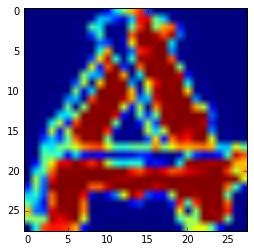

In [15]:
# verify the data is still good after loaded into tensors
pickle_file = train_datasets[0] # index 0 should give all As. 1 = all Bs etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f) # unpickle
    sample_idx = np.random.randint(len(letter_set)) # pick a random sample in the set
    sample_image = letter_set[sample_idx, :, :] # extract the a 2D slice
    plt.figure()
    plt.imshow(sample_image)

We then merge and prune the traing data as needed. Note we also split two blocks in addition to training set of the data for validation set and test set. The validation set is useful for tuning the hyperparameters in our model while the test set is used for testing the generalization of our model.

In [16]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class                
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

('Training:', (200000, 28, 28), (200000,))
('Validation:', (10000, 28, 28), (10000,))
('Testing:', (10000, 28, 28), (10000,))


We also want to apply some randomness to our data input by shuffling the feature set and associted labels.

In [18]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Finally, we can save our data for later use. (e.g. train our deep model)

In [19]:
pickle_file = 'notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [20]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 690800441)


Here we use the logistic regression model provided in sklearn to train our multinomial classifier. Note that we use only a fraction of the original training set (5000 examples) and pay attention to the speed of training. Linear model is very useful in many circumstances, but it sometimes scales not very well with large amount of data. This is where deep learning comes in to rescue and we can see it clearer in the later portion of the tutorial.

In [21]:
lg = LogisticRegression()
X_train = train_dataset.reshape(train_dataset.shape[0], image_size*image_size)
X_test = test_dataset.reshape(test_dataset.shape[0], image_size*image_size)
lg.fit(X_train[:5000], train_labels[:5000])
lg.score(X_test, test_labels)

0.85260000000000002

## Deeper training with TensorFlow

Now that we trained our simple classifier we will start working on our first deep learning model. To be able to do that we need to use the deep learning tool called [TensorFlow](https://www.tensorflow.org/). There are [several ways](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html) to install tensorflow on your machine, one way is use pip install tensorflow on your local machine by executing the following commands (I am using Mac as an example, but you can look for commnds for other OSs [here](https://www.tensorflow.org/versions/r0.11/get_started/os_setup.html#pip-installation):

Install python pip utility if not already:
    
    Mac OS X
    $ sudo easy_install pip
    $ sudo easy_install --upgrade six

Export url for tensorflow-CPU image:

    Mac OS X, CPU only, Python 2.7:
    $ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.11.0rc2-py2-none-any.whl

Install using pip:

    # Python 2
    $ sudo pip install --upgrade $TF_BINARY_URL

Now that we installed tensorflow, we can import the modules we needed for training our deep model. (Be sure to restar the notebook if you just installed tensorflow after openning the current notebook)
        

        

In [2]:
import tensorflow as tf
from six.moves import range

We'll reload the picke files we genereate before as our input data.

In [7]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


We'll flatten the input features as 1d numpy array and encode the labels using one-hot encoding. (e.g. if we have 3 classes, 0 will map to (1, 0, 0), 1 will map tp (0,1,0), etc.)

In [8]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs(e.g. training set, validation set, test set), the variables(parameters in weight matrix and biases), and the operations look like(our model, loss function, and optimizer). These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [133]:
# get the predictions for given data and parameters (this is a helper function to generate layer output given output from last layer)
def get_predictions(dataset, weights, biases, dropout=False, keep_rate=0.5):
    if len(weights) == 1:
        logits = tf.matmul(dataset, weights[0]) + biases[0]
    else:
        activation = dataset
        for i in range(len(weights) - 1):
            output = tf.nn.relu(tf.matmul(activation, weights[i]) + biases[i])
            if dropout:
                output = tf.nn.dropout(output, keep_rate)
            activation = output
        logits = tf.matmul(activation, weights[-1]) + biases[-1]
    return logits
 
# below are some parameters needed to configure our model    
batch_size=128  # small chunck of training set fed into model
feature_size=784 # 28x28 image
label_size=10 # A~J labels
layer_config=[784, 10] # the 1st/last is feature_size/label_size, in the middle are the number of nodes in each hidden layer

In [134]:
# This is where you configure the tensorflow computation graph
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, feature_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, label_size))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    drop_out = tf.placeholder(tf.int32)
    global_step = tf.Variable(0)

    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random values following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = []
    biases = []
    for i in range(len(layer_config) - 1):
        weights.append(tf.Variable(tf.truncated_normal([layer_config[i], layer_config[i+1]])))
        biases.append(tf.Variable(tf.zeros([layer_config[i+1]])))

    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute
    # the softmax and cross-entropy (it's one operation in TensorFlow, because
    # it's very common, and it can be optimized). We take the average of this
    # cross-entropy across all training examples: that's our loss.
    logits = get_predictions(tf_train_dataset, weights, biases, dropout, 0.5)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    # add regularization if beta_regul provided
    total = 0.0
    for weight in weights:
        total += tf.nn.l2_loss(weight)
    loss += beta_regul * total

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_logits = get_predictions(tf_valid_dataset, weights, biases, 0)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_logits = get_predictions(tf_test_dataset, weights, biases, 0)
    test_prediction = tf.nn.softmax(test_logits)

As you may have noticed, instead of applying constant inputs (as how we train our simple classifier before) to the computation graph, now we are using Placerholder nodes for the training set and associated labels (so that we can feed a small amount of data to our graph model each time). 

The reason for this is that the original gradient descent method is very hard to scale. Roughly speaking, if a loss function takes N floating point operations, computing its gradient will ~3N operations.   Instead we'll use stochastic gradient descent(SGD) which uses a small random sample of the whole training data to estimate our loss function and gradient. Here we trade many more iterations for unit loss and gradient computation cost. In a general sense, although this estimate is very rough (we are going to see some techniques to improve it later), it's much more efficient than gradient descent. SGD is the core idea behind deep learning to make it scalable with massive dataset.

In [159]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def run_session_sgd(graph, display_step=500, num_steps=3001, batch_size=128, deed_dict={}, beta=0.0, d=0):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.b
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta, drop_out : d}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % display_step == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

In [136]:
run_session_sgd(graph=graph)

Initialized
Minibatch loss at step 0: 14.095301
Minibatch accuracy: 20.3%
Validation accuracy: 18.6%
Test accuracy: 19.2%
Minibatch loss at step 500: 1.124421
Minibatch accuracy: 77.3%
Validation accuracy: 75.2%
Test accuracy: 83.0%
Minibatch loss at step 1000: 1.329740
Minibatch accuracy: 77.3%
Validation accuracy: 75.9%
Test accuracy: 84.0%
Minibatch loss at step 1500: 0.905100
Minibatch accuracy: 81.2%
Validation accuracy: 76.8%
Test accuracy: 84.8%
Minibatch loss at step 2000: 0.962788
Minibatch accuracy: 81.2%
Validation accuracy: 77.4%
Test accuracy: 85.4%
Minibatch loss at step 2500: 0.912956
Minibatch accuracy: 77.3%
Validation accuracy: 78.0%
Test accuracy: 86.1%
Minibatch loss at step 3000: 1.017252
Minibatch accuracy: 79.7%
Validation accuracy: 78.2%
Test accuracy: 86.4%


Now that we applied SGD, we can made modifications to the code to include a 1-hidden layer neural network with rectified linear units nn.relu() and 1024 hidden nodes. The reatified linear unit(relu) funtion serves as the hidden layer of our neural network. It bascially add some non-linearity to our model resulting in a prediction model like this: input data -> W1(1st linear function) -> relu(non-linear function) -> W2(2nd linear function) -> output.You can read more abou relu [here](https://en.wikipedia.org/wiki/Rectifier_(neural_networks).

In [141]:
layer_config=[784, 1024, 10]
# due to code line count limit, I move the graph configuration code into a separate file
# the relu function is tensorflow is just tf.nn.relu()
execfile('tf_graph_config_1_hidden.py')

We can reuse our SGD run process as before and note that we have improve our accuracy on both validation set and test set using 1-hidden layer neuro network. Congratulations! Now you have a basic neuro network that you can use to train. 

In [142]:
run_session_sgd(graph=graph)

Initialized
Minibatch loss at step 0: 258.307526
Minibatch accuracy: 12.5%
Validation accuracy: 24.6%
Test accuracy: 26.4%
Minibatch loss at step 500: 24.330862
Minibatch accuracy: 78.9%
Validation accuracy: 77.7%
Test accuracy: 85.3%
Minibatch loss at step 1000: 8.958380
Minibatch accuracy: 78.1%
Validation accuracy: 81.7%
Test accuracy: 88.5%
Minibatch loss at step 1500: 6.764034
Minibatch accuracy: 88.3%
Validation accuracy: 80.9%
Test accuracy: 87.5%
Minibatch loss at step 2000: 2.423084
Minibatch accuracy: 88.3%
Validation accuracy: 82.0%
Test accuracy: 88.9%
Minibatch loss at step 2500: 3.995928
Minibatch accuracy: 80.5%
Validation accuracy: 81.9%
Test accuracy: 89.0%
Minibatch loss at step 3000: 2.688911
Minibatch accuracy: 80.5%
Validation accuracy: 82.9%
Test accuracy: 89.8%


## Apply-regularization-techniques

Previously we train a simple neuro-network with just one hidden layer and 1024 nodes. In order to improve the model performance, we can either increase the number of nodes in a single hidden layer(width) or increase the number of layers(depth). This is where the central idea of deep learning comes into play.

Generally, we want to try deep networks that are very big as a starting point for our data and try our best to prevent them from overfitting over the training process. There are several techniques to prevent your data from overfitting: 1. early termination 2. regularization 3. dropout. Early termination means we stop exacly when performance plateaus. Regularization usually means adding a L2 norm term multiplied with a constant to penalize big weights. Dropout is a  used to force the model to learn redundant representations of your data to make your model more robust and away from overfitting. It works like this: each time when one layer's output (called activations) goes as an input to the next layer, randomly set half of the activations to zero. 

In the following section we are going apply a combination of these techniques to improve the performance of neuro networks. Firstly lets look into regularization. Note below we use tf.nn.l2_loss to compute the L2 norm of the weights and supply the multiplied constant as an node variable beta_regul (using tf.placeholder). The tensorflow model code is almost the same as before except we add a small term in the loss function to regularize our parameters. 

In [98]:
# Note the code below, initiallly we assigne beta_regul to 0.0 so we don't have regularization
# add regularization if beta_regul provided
total = 0.0
for weight in weights:
    total += tf.nn.l2_loss(weight)
loss += beta_regul * total

As beta_regul is yet another hyperparamer in our model. Here we just simply use 1e-3 as the beta_regul value, since this what we find out to give best performance by experimenting.

In [100]:
run_session_sgd(graph=graph, beta=1e-3)

Initialized
Minibatch loss at step 0: 1137.573242
Minibatch accuracy: 8.6%
Validation accuracy: 17.6%
Test accuracy: 18.4%
Minibatch loss at step 500: 410.241577
Minibatch accuracy: 71.1%
Validation accuracy: 79.0%
Test accuracy: 86.4%
Minibatch loss at step 1000: 230.384918
Minibatch accuracy: 78.9%
Validation accuracy: 80.3%
Test accuracy: 87.5%
Minibatch loss at step 1500: 137.189484
Minibatch accuracy: 82.8%
Validation accuracy: 81.8%
Test accuracy: 89.1%
Minibatch loss at step 2000: 82.147705
Minibatch accuracy: 82.0%
Validation accuracy: 83.3%
Test accuracy: 90.2%
Minibatch loss at step 2500: 50.012856
Minibatch accuracy: 78.9%
Validation accuracy: 84.0%
Test accuracy: 91.1%
Minibatch loss at step 3000: 30.452335
Minibatch accuracy: 84.4%
Validation accuracy: 85.2%
Test accuracy: 91.9%


As you can see, the performance across all datasets improves after we introduce a regularization term. Now, lets move to dropout. Firstly, let's see what happens if we have a very samll batch of data fed into model each time.

In [155]:
num_steps = 101
num_bacthes = 3
execfile('tf_graph_config_1_hidden.py')
execfile('small_batch_run.py')

Initialized
Minibatch loss at step 0: 420.971527
Minibatch accuracy: 9.4%
Validation accuracy: 33.7%
Test accuracy: 36.2%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Test accuracy: 70.3%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Test accuracy: 70.3%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Test accuracy: 70.3%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Test accuracy: 70.3%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 63.5%
Test accuracy: 70.3%


As what we've expected, although the model appears to fit the training set very well(nearly 100%), it performs poorly upon validation and test. Even if we have regularization, the data applied is too small thus bias our traing. Let's add dropout mechanism using tensorflow's nn.dropout().

In [156]:
# the basic usage of dropout is highted below, you can refer to the code if curious
# """hid_lay_out = tf.nn.relu(tf.nn.dropout(lay1_out, 0.5))"""
execfile('tf_graph_config_dropout.py')
execfile('small_batch_run.py')

Initialized
Minibatch loss at step 0: 991.516296
Minibatch accuracy: 11.7%
Validation accuracy: 23.1%
Test accuracy: 24.9%
Minibatch loss at step 20: 358.600311
Minibatch accuracy: 89.8%
Validation accuracy: 64.3%
Test accuracy: 71.6%
Minibatch loss at step 40: 338.779022
Minibatch accuracy: 91.4%
Validation accuracy: 69.0%
Test accuracy: 76.2%
Minibatch loss at step 60: 306.065552
Minibatch accuracy: 98.4%
Validation accuracy: 69.6%
Test accuracy: 77.3%
Minibatch loss at step 80: 327.719574
Minibatch accuracy: 95.3%
Validation accuracy: 68.3%
Test accuracy: 75.5%
Minibatch loss at step 100: 294.624634
Minibatch accuracy: 98.4%
Validation accuracy: 71.2%
Test accuracy: 78.1%


We've improved our performance on validation/test set by ~8% by adding dropout mechanism during training process. Now let's put all the pieces together to construct our best performance training model by apply regularization, dropout, and multi-layer model. Below we have a 3-hidden layer model each with decreasing number of nodes [1024, 256, 128], and a keep rate of 0.5. Note here we also apply an exponentially decaying learning rate among training iterations to provide best performance.

In [160]:
# due to length constraint essential code is highlighted below, refer to code if more curious
# # Parameters
# batch_size = 128
# num_hidden_nodes1 = 1024
# num_hidden_nodes2 = 512
# num_hidden_nodes3 = 256

# # Training computation.
# lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
# drop1 = tf.nn.dropout(lay1_train, 0.5)
# lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
# ...

# # Regularize 
# loss +=  beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + tf.nn.l2_loss(weights4)

# # Optimizer.
# learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase=True)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
execfile('tf_graph_config_all.py')

In [158]:
run_session_sgd(graph, display_step=4000, num_steps=20001, batch_size=128, beta=1e-3, d=1)

Initialized
Minibatch loss at step 0: 2.758533
Minibatch accuracy: 14.1%
Validation accuracy: 22.8%
Test accuracy: 24.5%
Minibatch loss at step 4000: 0.388222
Minibatch accuracy: 89.1%
Validation accuracy: 87.3%
Test accuracy: 93.7%
Minibatch loss at step 8000: 0.631142
Minibatch accuracy: 78.9%
Validation accuracy: 88.5%
Test accuracy: 94.6%
Minibatch loss at step 12000: 0.418894
Minibatch accuracy: 88.3%
Validation accuracy: 89.0%
Test accuracy: 95.0%
Minibatch loss at step 16000: 0.217906
Minibatch accuracy: 93.0%
Validation accuracy: 89.7%
Test accuracy: 95.3%
Minibatch loss at step 20000: 0.403385
Minibatch accuracy: 85.9%
Validation accuracy: 90.0%
Test accuracy: 95.4%


## Example application: convolutional neuro network

In addition to basic neuro networks, we can make our deep network convolutional to reduce feature map size and increase depth when processing images. You can read more about [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network) (convolutional neuro networks). Below is an example of runnning convolutional deep neuro networks on the classic MNIST data with tensorflow. It may take quite a while depending on your local machine since we are using fairly complex model with many itrerations.

In [ ]:
execfile('MINST_CNN_example.py')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Iter 1280, Minibatch Loss= 25523.613281, Training Accuracy= 0.23438
Iter 2560, Minibatch Loss= 10357.601562, Training Accuracy= 0.46875
Iter 3840, Minibatch Loss= 9162.200195, Training Accuracy= 0.61719
Iter 5120, Minibatch Loss= 3597.420410, Training Accuracy= 0.81250
Iter 6400, Minibatch Loss= 1682.246338, Training Accuracy= 0.86719
Iter 7680, Minibatch Loss= 6595.059570, Training Accuracy= 0.71094
Iter 8960, Minibatch Loss= 2800.517090, Training Accuracy= 0.78906
Iter 10240, Minibatch Loss= 1820.602051, Training Accuracy= 0.86719
Iter 11520, Minibatch Loss= 1927.715698, Training Accuracy= 0.89844
Iter 12800, Minibatch Loss= 2979.541504, Training Accuracy= 0.81250
Iter 14080, Minibatch Loss= 1133.863281, Training Accuracy= 0.89062
Iter 15360, Minibatch Loss= 1623.843506, Training Accuracy= 0.89062

## Summary and Reference

There is a lot of things we can do with deep learning and tensorflow. To learn more please check out the following links:
1. [tensorflow tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/index.html)
2. [deep learning tutorial](https://www.toptal.com/machine-learning/an-introduction-to-deep-learning-from-perceptrons-to-deep-networks)
3. [introduction to CNN](https://miguelgfierro.com/blog/2016/a-gentle-introduction-to-convolutional-neural-networks/)
4. [many tensorflow examples](https://github.com/aymericdamien/TensorFlow-Examples)